In [1]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import skimage.io
from random import shuffle
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from tensorflow import keras
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
#from keras.engine import Layer, InputSpec
#from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
#from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, GlobalAveragePooling2D, Attention, Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import sparse_categorical_crossentropy

2023-02-21 11:46:18.194068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
WORKERS = 2
CHANNELS = 3
IMG_WIDTH = 512 #previously 244
IMG_HEIGHT = 512 #previously 244

import warnings
warnings.filterwarnings("ignore")
#IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train


IMG_SIZE = 512
TARGET_SIZE = (512, 512)
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 5

DIR = "/Users/andrewcosta/Desktop/Milan/AMS/project/aptos2019-blindness-detection/"
TRAIN_DIR = DIR + "train.csv"
TEST_DIR = DIR + "test.csv"
TRAIN_IMG_PATH = DIR + "train_images/"
TEST_IMG_PATH = DIR + "test_images/"

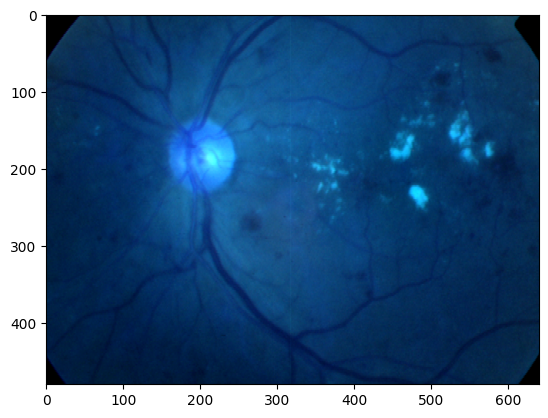

In [4]:
x = cv2.imread('/Users/andrewcosta/Desktop/Milan/AMS/project/aptos2019-blindness-detection/test_images/01c5ba195207.png')
plt.imshow(x)

In [5]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DIR)

# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DIR)

# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [6]:
# number of unique classes
np.sort(train_df['diagnosis'].unique())

array([0, 1, 2, 3, 4])

In [7]:
def get_preds_labels(model, generator):
    preds = [] # set prediction list
    labels = [] # set labels list

    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

### Exploratory Data Analysis

Text(0, 0.5, 'Frequency')

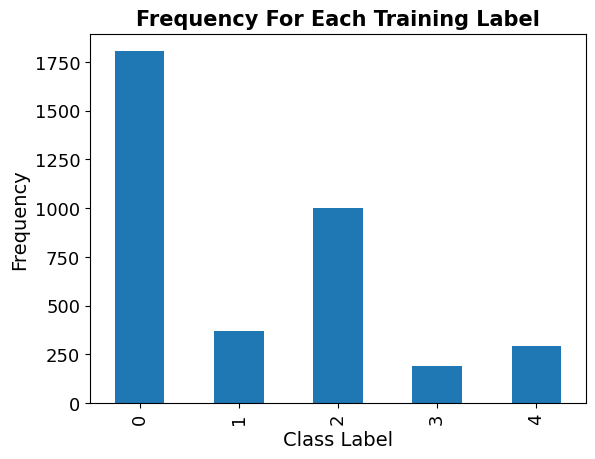

In [8]:
train_df['diagnosis'].value_counts().sort_index().plot.bar() # heavy data imbalance: suggest statified k-fold cross val
plt.title('Frequency For Each Training Label',
            weight='bold',
            fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Class Label',
            fontsize=14)
plt.ylabel('Frequency',
            fontsize=14)


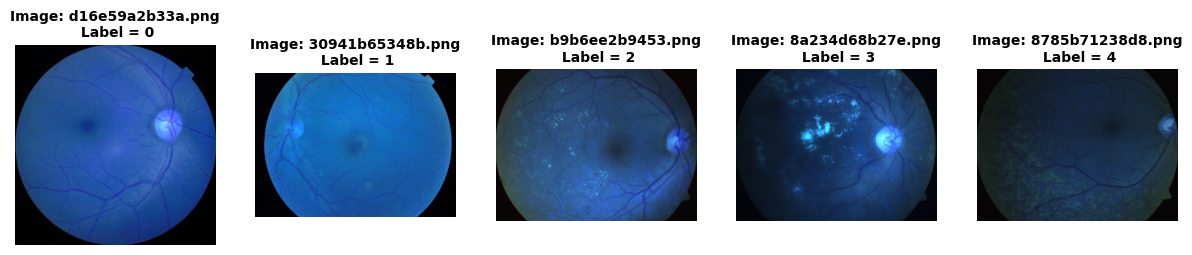

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [10]:
# use colour instead of grey
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [13]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
    return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = load_ben_color(image)
    image = crop_image_from_gray(image)
    #image = circle_crop(img=image) # delete if necessary
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    
    return image

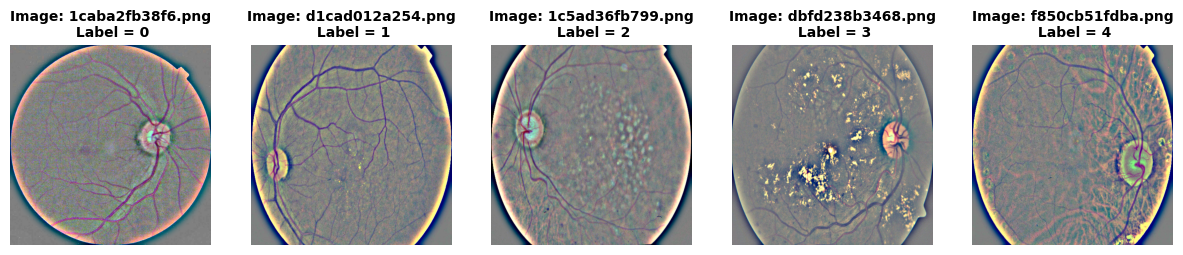

In [14]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{TRAIN_IMG_PATH}{image_name}"))
   # X = circle_crop(X)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [15]:
y_labels = train_df['diagnosis'].values

In [16]:
BATCH_SIZE = 5

train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   preprocessing_function=preprocess_image,
                                   rescale= None)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory=TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other',
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory=TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other',
                                                    subset='validation')

Found 3113 validated image filenames.
Found 549 validated image filenames.


## Base Model

In [17]:
def base_model(loss, optimizer, metrics):
    model = Sequential()
    model.add(Convolution2D(kernel_size=(5, 5), filters=8, activation='relu', padding='VALID'))
    model.add(MaxPooling2D(pool_size=(6, 6)))
    model.add(Flatten())
    model.add(Dense(units=5, activation='softmax'))


    model.compile(optimizer=optimizer,
                  loss = loss,
                  metrics = metrics
    )
    print(model.summary)
    return model

In [18]:
tf.random.set_seed(0)

base_model = base_model(
    loss=sparse_categorical_crossentropy, 
    optimizer="adam", 
    metrics=['accuracy']
)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x16398ae90>>


2023-02-21 11:57:42.587738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
base_history = base_model.fit(train_generator, epochs=5)

Epoch 1/5
623/623 [==============================] - 1318s 2s/step - loss: 17.2672 - accuracy: 0.5207
Epoch 2/5
623/623 [==============================] - 1272s 2s/step - loss: 5.7498 - accuracy: 0.5040
Epoch 3/5
623/623 [==============================] - 2137s 3s/step - loss: 4.4021 - accuracy: 0.5104
Epoch 4/5
623/623 [==============================] - 4340s 7s/step - loss: 3.5357 - accuracy: 0.5239
Epoch 5/5
623/623 [==============================] - 1283s 2s/step - loss: 3.7775 - accuracy: 0.5034


<AxesSubplot: >

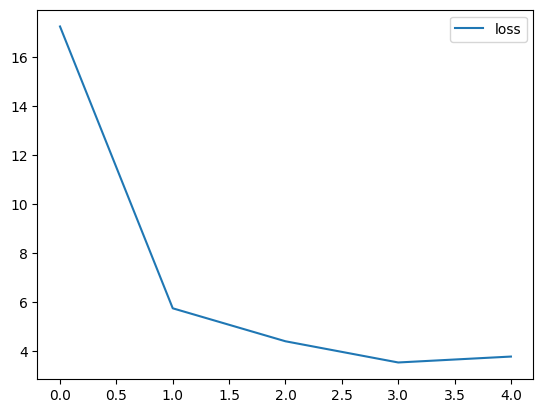

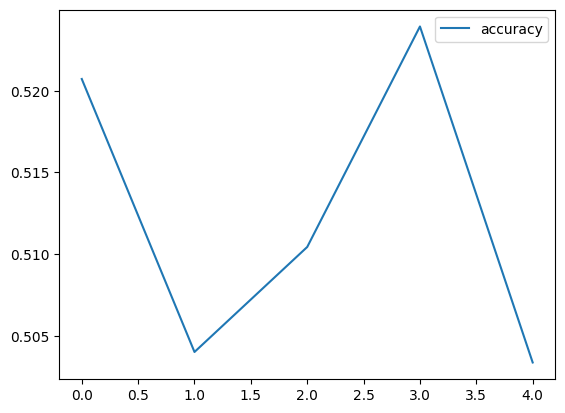

In [21]:
history_df = pd.DataFrame(base_history.history)
history_df[['loss']].plot()
history_df[['accuracy']].plot()

In [ ]:
print('Accuracy on val set: ',
      str(base_model.evaluate(val_generator, verbose=False)[1]))

## Another Base Model

In [ ]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

def second_model(loss, optimizer, metrics):
    """
    loss='categorical_crossentropy', 
    optimizer="adam", 
    metrics=['accuracy']
    """
    model = Sequential()
    model.add(Convolution2D(8,kernel_size=(5,5),padding="VALID", activation = 'relu'))
    model.add(MaxPooling2D((6,6)))
    model.add(Convolution2D(16,kernel_size=(5,5),padding="VALID", activation = 'relu'))
    model.add(MaxPooling2D((6,6)))
    model.add(Convolution2D(32,kernel_size=(5,5),padding="VALID", activation = 'relu'))
    model.add(MaxPooling2D((6,6)))
    model.add(Flatten())
    #model.add(Dense(100, activation = 'relu'))
    #model.add(Dropout((0.5)))
    #model.add(Dense(100, activation = 'relu'))
    #model.add(Dropout((0.5)))
    #model.add(Flatten())
    model.add(Dense(5, activation = 'softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

#model.summary()

In [ ]:
second_model = second_model(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                            optimizer="adam", 
                            metrics=['accuracy'])

In [ ]:
second_model.fit(train_generator, epochs=5)

## Another Another Model

In [ ]:
def model_mc(loss, optimizer, metrics):
   
    model_mc = Sequential()
    model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
    model_mc.add(Dropout((0.3)))
    model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
    model_mc.add(Dropout((0.3)))
    model_mc.add(MaxPooling2D((2,2)))
    model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
    model_mc.add(Dropout((0.3)))
    model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
    model_mc.add(Dropout((0.3)))
    model_mc.add(MaxPooling2D((2,2)))
    model_mc.add(Flatten())
    model_mc.add(Dense(100, activation = 'relu'))
    model_mc.add(Dropout((0.3)))
    model_mc.add(Dense(50, activation = 'relu'))
    model_mc.add(Dropout((0.3)))
    model_mc.add(Dense(5, activation = 'softmax'))

    model_mc.compile(loss=loss, optimizer=optimizer, metrics=metrics)


    return model_mc

In [ ]:
import tensorflow.keras.backend as K
third_model = model_mc(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                       optimizer="adam", 
                       metrics=['accuracy'])

In [ ]:
third_model.fit(train_generator, epochs=5)

## CNN with Attention

In [ ]:
def attn_cnn_model(loss, optimizer, metrics):
    model = Sequential()
    model.add(Attention())
    model.add(Convolution2D(kernel_size=(5, 5), filters=8, activation='relu', padding='VALID'))
    model.add(MaxPooling2D(pool_size=(6, 6)))
    model.add(Flatten())
    model.add(Dense(units=5, activation='softmax'))


    model.compile(optimizer=optimizer,
                  loss = loss,
                  metrics = metrics
    )
    print(model.summary)
    return model

In [ ]:
attention_cnn = attn_cnn_model(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                               optimizer="adam", 
                               metrics=['accuracy'])

In [ ]:
attention_cnn.fit(train_generator, epochs=5)

## Bayesian CNN

In [ ]:
def bayesian_cnn(loss, optimizer, metrics):
      
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (244. *1.0)

    model_vi = Sequential()
    model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
    model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
    model_vi.add(tf.keras.layers.Flatten())
    model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tfp.layers.DenseFlipout(5, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

    model_vi.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model_vi

In [ ]:
bcnn = bayesian_cnn(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    optimizer="adam", 
                    metrics=['accuracy'])

In [ ]:
bcnn.fit(train_generator, epochs=5)

## Second Bayesian CNN

In [ ]:
def second_bayesian_cnn(loss, optimizer, metrics):
      
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (244. *1.0)

    model_vi = Sequential()
    model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(5,5),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tf.keras.layers.MaxPooling2D((6,6)))
    model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(5,5),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tf.keras.layers.MaxPooling2D((6,6)))
    model_vi.add(tf.keras.layers.Flatten())
    model_vi.add(tfp.layers.DenseFlipout(5, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

    model_vi.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model_vi

In [ ]:
second_bayesian = second_bayesian_cnn(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                      optimizer="adam", 
                                      metrics=['accuracy'])

In [ ]:
second_bayesian.fit(train_generator, epochs=5)

## Third Bayesian CNN

In [ ]:
def third_bayesian_cnn(loss, optimizer, metrics):
      
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (244. *1.0)

    model_vi = Sequential()
    model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(5,5),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
    model_vi.add(tf.keras.layers.MaxPooling2D((6,6)))
    model_vi.add(tf.keras.layers.Flatten())
    model_vi.add(tfp.layers.DenseFlipout(5, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

    model_vi.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model_vi

In [ ]:
third_bayesian = third_bayesian_cnn(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                    optimizer="adam", 
                                    metrics=['accuracy'])

In [ ]:
third_bayesian.fit(train_generator, epochs=5)

## Fourth Bayesian

In [ ]:
kl_divergence_function = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(244., dtype=tf.float32)

model = tf.keras.Sequential([
    
    tfp.layers.Convolution2DFlipout(8, kernel_size=(3,3), strides=(1,1), 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1a", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(4,4), pool_size=(4,4), padding="same"),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(5, kernel_divergence_fn=kl_divergence_function),
])

In [ ]:
learning_rate = 1.0e-3
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

In [ ]:
batch_size = 5
history = model.fit(train_generator,
                    epochs=25, 
                    verbose=1, 
                    batch_size=batch_size,
                    validation_data=val_generator,
                    validation_freq=5)

## Hyperparameter Tuning: CNN

In [ ]:
import keras_tuner as kt

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
LeakyReLU = LeakyReLU(alpha=0.1)

In [ ]:
def model_builder(hp):
    '''
    Args:
    hp - Keras tuner object
    '''
  # Initialize the Sequential API and start stacking the layers
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    # Tune the number of units in the first Dense layer
  # Choose an optimal value between 8-512
    hp_units = hp.Int('units', min_value=8, max_value=, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
  # Add next layers
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(5, activation='softmax'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='accuracy',
                     max_epochs=10,
                     factor=3, # factor which you have seen above 
                     directory='dir', # directory to save logs 
                     project_name='hyperband')

In [ ]:
tuner.search_space_summary() 

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# Perform hypertuning
tuner.search(train_generator, epochs=10, callbacks=[stop_early])

In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]

In [ ]:
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()
h_model.fit(train_generator, epochs=10)